## Phase ordering of an unlabeled set of oscillating signals

NB: I built this notebook in just a few hours to help a colleague with his research, possibly not everything is well commented and robust.

Assume we are provided with a set of samples, representing several oscillating signals, each with their own phase, but a common period (corresponding to an external time). We want to find the ordering of these samples, so that you can assign a given time label to each of them. For instance, you could be working with scRNAseq data taken at various times from different people. All these people have the same genes that get expressed in (more or less) the same way, although with a different phase, but if, as commonly done, the time at which the data was acquired is missing, the biological clock of these people would be an unknown factor of variability in the system.

Basically, we would have a model of this form: 

$$E_{i,t} = \mu_i + R_i cos(\phi_i + \phi_t)$$

In this formula, $i$ is the index of the sample, $t$ is the time of the sample, $\mu_i$ is just a sample specific intercept, $R_i$ is the sample specific amplitude, and $\phi_i$ is the sample specific phase. $\phi_t$ corresponds to the external time, i.e. $\phi_t = 2\pi t/T$. In this notebook, we want to optimize, $\mu_i$, $R_i$, $\phi_i$ and $\phi_t$ for each sample. 



Let's start by making the standard imports for data analysis.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import copy
import seaborn as sns
pal = sns.color_palette("hls", 12)

# High resolution plot
import matplotlib_inline.backend_inline as backend_inline 
backend_inline.set_matplotlib_formats('png2x')

# Remove warnings for the final notebook
import warnings
warnings.filterwarnings('ignore')


Let's now import a real experimental scRNAseq dataset, available [here](https://pubmed.ncbi.nlm.nih.gov/26554015/), and turn it into a dictionary of gene expression. We have several hundreds genes, with a time-resolution of two hours, i.e. 12 samples per day, and 4 replicates per sample.

In [2]:
def LoadAtger(
    load_path="../Zonation_project/analysis_zonation/Datasets/Atger/atger_al_wt_FromPaper.txt",
):
    dic_atg = {}
    # Load text file in a df
    df = pd.read_csv(load_path, sep="\t", index_col="Gene_Symbol")
    names = [
        "Exon_WT_ZT" + "0" + str(i) if i < 10 and i != 6 else "Exon_WT_ZT" + str(i)
        for i in range(0, 24, 2)
    ]

    # Compute mean expression and std across the 4 conditions
    for index, val_gene in df.iterrows():
        general_array = np.vstack(
            [
                [
                    df.loc[index, name + ".a"],
                    df.loc[index, name + ".b"],
                    df.loc[index, name + ".c"],
                    df.loc[index, name + ".d"],
                ]
                for name in names
            ]
        )
        dic_atg[index.lower()] = np.log2(general_array + 10 * 10**-6) - np.log2(20 * 10**-6)

    return dic_atg

dic_atg = LoadAtger()


We now remove all the genes with missing values form the dataset

In [3]:
l_to_del = []
for gene, val in dic_atg.items():
    if val.shape==(48,2):
        l_to_del.append(gene)

# Delete the genes with missing datapoints
for x in l_to_del:
    if x in dic_atg:
        del dic_atg[x]

l_names = list(dic_atg.keys())
for t in range(12):
    for idx_name, name in enumerate(l_names):
        val = dic_atg[name]
        for rep in range(4):
            if np.isnan(val[t,rep]):
                l_to_del.append(name)

# Delete the genes with nan values
for x in l_to_del:
    if x in dic_atg:
        del dic_atg[x]


We now want to find the most oscillating genes. To this end, we run a simple linear regression with just one harmonics for each gene (i.e. $\cos$ and $\sin$). I happen to have the code to do the regression myself, but using scikit-learn would work just as well here.

In [4]:
# Find the most oscillating genes
class LinearRegression():
    def __init__(self, Y, dic_X):
        """
        Y: observations vector
        dictionnary of predictors: design matrix
        """
        self.Y = Y[:,np.newaxis]
        self.dic_X = dic_X
        self.n = len(Y)

    def make_complete_regression(self, chosen_predictors, no_intercept = False):
        p = len(chosen_predictors)
        # Create design matrix
        X = np.ones(self.n)[:,None].T
        for pred in chosen_predictors:
            X = np.vstack( (X, self.dic_X[pred]) )
        if no_intercept:
            X = np.delete(X,0,0)
        # Make X a matrix with predictors as horizontal vectors
        X = X.T
        X2_inv = np.linalg.inv(X.T @ X)
        # Get coef matrix
        B =  X2_inv @ X.T @ self.Y
        # Get predictions
        Y_pred = X@B
        # Compute s
        s2 =  (1/(self.n-p)) * ((self.Y - Y_pred).T @ (self.Y - Y_pred))
        # Compute SE Parameters
        SE = (s2 * X2_inv)**0.5
        # Compute Y_mean
        Y_mean = np.mean(self.Y)
        # Compute r2
        r2 = np.squeeze(((Y_pred -Y_mean).T @ (Y_pred -Y_mean) ) / (   (self.Y-Y_mean).T @ (self.Y -Y_mean) ))
        # Compute adjusted r2
        adj_r2 = 1-(1-r2) * (self.n -1)/(self.n-p-1)
        # Compute log-likelihood 
        try:
            minus_two_ll = self.n*(np.log(2*np.pi)+1+np.log((np.sum((self.Y - Y_pred).T @ (self.Y - Y_pred))/self.n)))
        except:
            minus_two_ll = np.nan
        # Compute AIC 
        aic =  minus_two_ll+(p+1)*2
        # Compute BIC 
        bic = minus_two_ll+np.log(self.n)*(p+1)

        return X, B, SE, adj_r2, aic, bic

Let's now run the regression for each gene, and only keep the oscillating ones according to the Bayesian Information Criterium (BIC).

In [5]:
w = 2*np.pi/24
Xt = np.array(list(range(0,24,2))*4)
dic_X = {'x': np.cos(w*Xt) , 'y': np.sin(w*Xt)}

dic_reg_atg = {}
for gene, val in dic_atg.items():
    Y = val.flatten('F')
    try:
        # Compare oscillating model with flat model
        chosen_predictors =['x','y']
        X_osc, B_osc, SE_osc, adj_r2_osc, aic_osc, bic_osc = LinearRegression(Y, dic_X).make_complete_regression(chosen_predictors)
        chosen_predictors =[]
        X_flat, B_flat, SE_flat, adj_r2_flat, aic_flat, bic_flat = LinearRegression(Y, dic_X).make_complete_regression(chosen_predictors)
        if bic_flat<bic_osc:
            dic_reg_atg[gene] = ['flat', X_flat, B_flat, SE_flat, adj_r2_flat, aic_flat, bic_flat]
        else:
            dic_reg_atg[gene] = ['osc', X_osc, B_osc, SE_osc, adj_r2_osc, aic_osc, bic_osc]
    except:
        print('Gene ', gene, ' was discarded of the analysis')

Let's plot of few genes to see what the data and regression actually looks like.

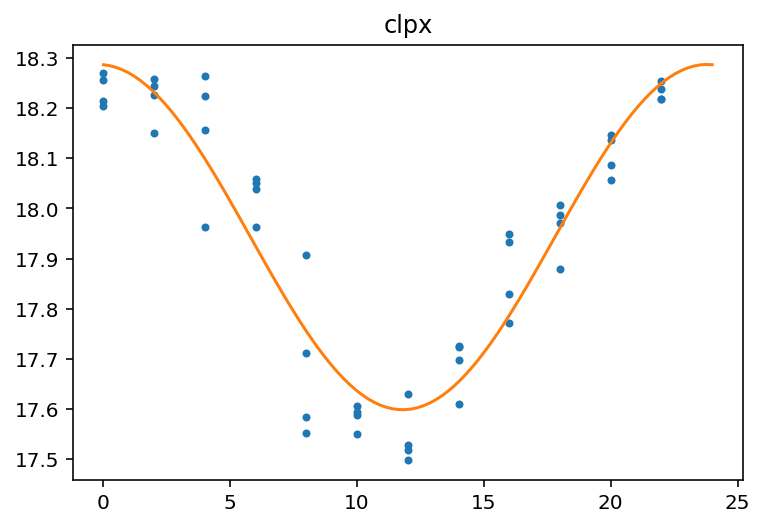

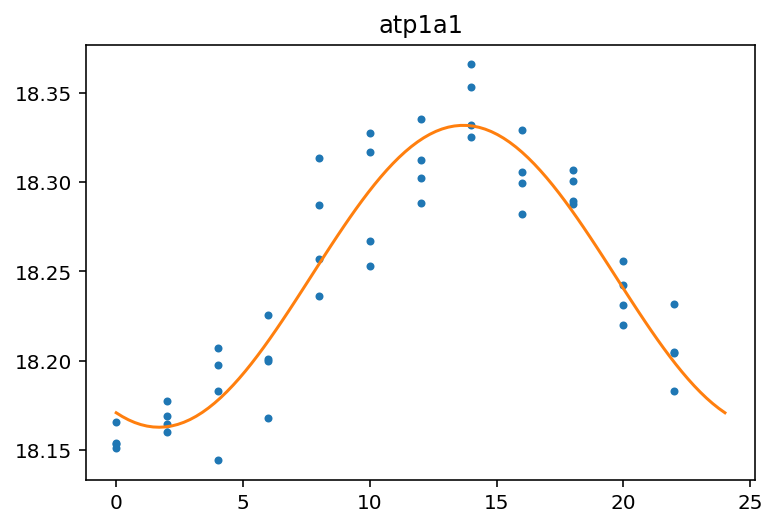

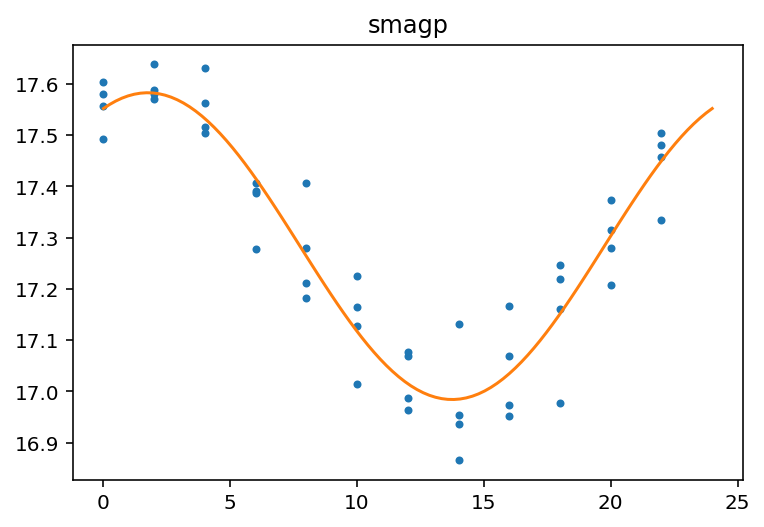

In [6]:
l_names = []
Xt_pred = np.linspace(0,24,100)
plotted = 0
for idx, (gene, reg) in enumerate(dic_reg_atg.items()):
    type_reg, X, B, SE, adj_r2, aic, bic = reg
    if type_reg=='flat':
        pass
    else:
        # Keep only the genes for which the R2 coefficient is above 0.75, as we have too many genes anyway
        if adj_r2>0.75:
            l_names.append(gene)
            if plotted<3:
                plt.plot(Xt, dic_atg[gene].flatten('F'), '.')
                plt.plot(Xt_pred, [float(B[0])]*len(Xt_pred)+B[1]*np.cos(w*Xt_pred)+B[2]*np.sin(w*Xt_pred))
                plt.title(gene)
                plt.show()
                plotted += 1

We can now prepare this data and run the optimization for all of our parameters. Basically, we need to concatenate the time $t$ and sample $i$ dimensions before inputing it to the optimizer. In theory, we could also randomize the samples by time of acquisition, but this is not actually needed as the timestamps are not provided to the optimizer.

In [7]:
# Make a matrix
l_atg = []
l_idx_names = []
l_time = []
for t in range(12):
    for idx_name, name in enumerate(l_names):
        val = dic_atg[name]
        l_idx_names.extend([idx_name] * 4)
        l_time.extend([t] * 4)
        l_atg.extend(val[t, :])

l_atg = np.array(l_atg)


In [8]:
def fun(x, l_idx_names, l_time, y):
    res = (
        x[l_idx_names]
        + x[l_idx_names + len(l_names)]
        * np.cos(x[l_idx_names + 2 * len(l_names)] + x[3 * len(l_names) + l_time])
        - y
    )
    return res


l_idx_names = np.array(l_idx_names)
l_time = np.array(l_time)
x0 = np.array([1.0] * len(l_names) * 3 + [1.0] * 12)

bounds = [
    [-np.inf] * len(l_names) * 2 + [0] * (len(l_names) + 12),
    [np.inf] * len(l_names) * 2 + [2 * np.pi] * (len(l_names) + 12),
]
res_robust = least_squares(
    fun, x0, loss="soft_l1", f_scale=0.1, bounds=bounds, args=(l_idx_names, l_time, l_atg)
)

params = res_robust.x


Get the reference external time phase from a known cycling gene, 'clpx'.

In [9]:
# Find the real phase using a known gene: clpx
clpx_idx = [idx for idx, x in enumerate(l_names) if x == "clpx"][0]

# Get parameters for clpx
mu = params[clpx_idx]
R = params[len(l_names) + clpx_idx]
phi_clpx = params[len(l_names) * 2 + clpx_idx]

# Get the real phase of clpx
type_reg, X, B, SE, adj_r2, aic, bic = dic_reg_atg["clpx"]
phase = np.arctan2(B[2], B[1]) % (2 * np.pi)
phase = phase[0]

print(phase)
print(phi_clpx)

# Shift all the phases such that the phase of clpx in the non-linear regression corresponds to the real phase
params_corrected = copy.copy(params)
params_corrected[-12 - len(l_names) :] -= params_corrected[-12]
params_corrected[-12 - len(l_names) :] = params_corrected[-12 - len(l_names) :] % (2 * np.pi)


6.230093438006649
2.2468263709219776


Display the final set of optimized phases.

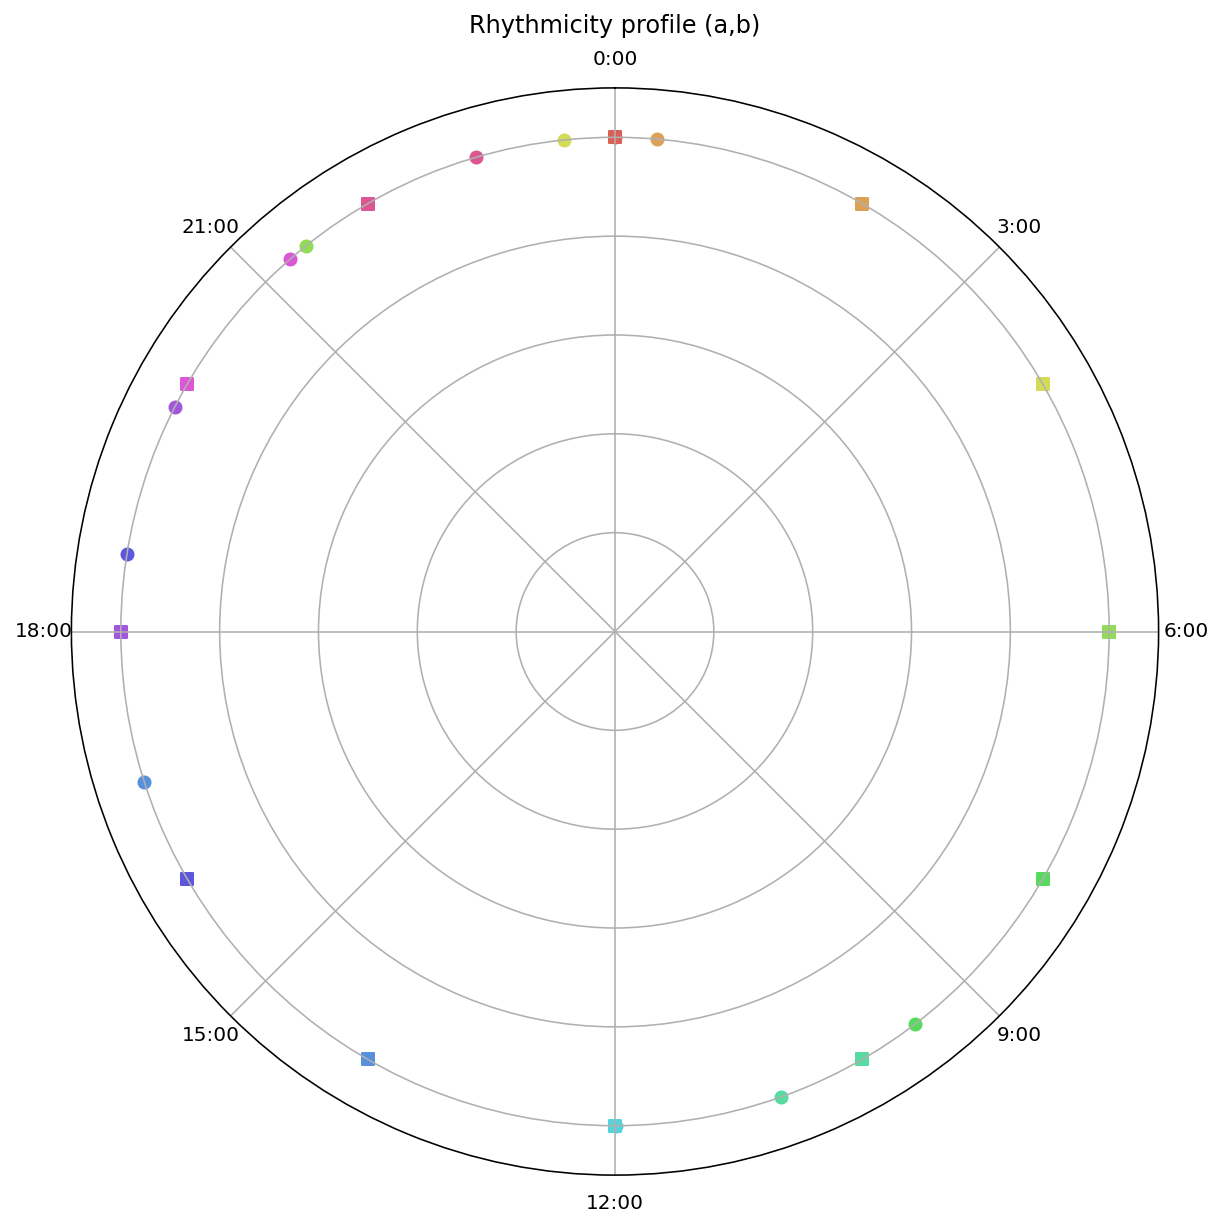

median error 2.201502192927184


In [10]:
# Plot the inferred phases vs real phases on a polar plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(210)  # get radial labels away from plotted line
ax.set_rlim([0, 1.1])
ax.set_yticklabels([])
# Set the label
ticks = ["0:00", "3:00", "6:00", "9:00", "12:00", "15:00", "18:00", "21:00"]
ax.set_xticklabels(ticks)
ax.set_title("Rhythmicity profile (a,b)", va="bottom")

l_error = []
for i in range(12):
    ax.scatter(params_corrected[-12 + i], 1, color=pal[i])
    ax.scatter(
        (i * 2) / 24 * 2 * np.pi,
        1,
        marker="s",
        color=pal[i],
    )
    l_error.append(abs((params_corrected[-12 + i] - (i * 2) / 24 * 2 * np.pi) % (2 * np.pi)))
plt.show()

print("median error", np.median(l_error) / (2 * np.pi) * 24)


Basically, the true phases are represented by coloured squares, and the inferred phases by the corresponding colour circles. It appears that the results are not perfect, but given that we're dealing with a noisy dataset, an median error of about 2h, means that we still get very helpful information out of the model.